# Introduction - Herd Immunity Estimate for Spain 

## Objectives
The goal of this project is to answer the following question: 
 - Will Spain reach herd immunity? 
 - When will that happen?  


## Steps
In order to answer the questions defined above, we need to accomplish the following steps: 
1. Calculate the increment in the expected number of deaths per day 
2. Calculate number of real infected people from 2 weeks ago backwards
3. Calculate a model that fit the evolution of infected people. The model will give us:
     - Predictions for future real infected and real deaths 
     - Ro
4. Having Ro and the Infections we have all the values in the equation to determine whether we´ll reach herd immunity  

## Disclaimer
By no means, you should take the conclusions from this project as statements. I am not a doctor, neither an expert in epidemics. 





In [41]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Decrement in deaths due to confinement

We are going to calculate deaths provoke by causes that should not occur during the confinement. Then we are going to subtract this number for the expected daily death. 

This is a very basic approach, but since we have no data about the death distribution accross the year we are going to assume these deaths happen following a uniform distribution. 

I got the information about causes of death per year in Spain from the following page: https://www.ine.es/jaxiT3/Tabla.htm?t=7947

In [154]:
deaths_causes = pd.read_csv("7947.csv", sep=";", thousands=".")

# These are the causes I have identified that should be reduced. 
non_existing_causes = ['090-102  XX.Causas externas de mortalidad']

# We are going to filter  only the information that we need
deaths_causes = deaths_causes[deaths_causes["Sexo"] == "Total"]
deaths_causes = deaths_causes[deaths_causes["Edad"] == "Todas las edades"]

# I am going to consider information about the last 5 years available 
deaths_causes = deaths_causes[deaths_causes["Periodo"] > 2013] 
deaths_causes = deaths_causes.loc[deaths_causes["Causa de muerte"].isin(non_existing_causes)]
deaths_causes = deaths_causes.groupby(by=["Causa de muerte"]).max() 
deaths_causes.drop(columns="Periodo")

,Sexo,Edad,Total
Causa de muerte,,,
090-102 XX.Causas externas de mortalidad,Total,Todas las edades,15837


In [155]:
# We are going to calculate the number of deaths that should be reduced due to quarantine per day
print(deaths_causes["Total"].sum())
death_to_discount = round(deaths_causes["Total"].sum() / 365,0)
death_to_discount

15837


43.0

# All-cause mortality


I got the information from this site: https://momo.isciii.es/public/momo/dashboard/momo_dashboard.html#nacional

In [209]:
mortality = pd.read_csv("data.csv")
mortality = mortality[mortality["nombre_sexo"] == "todos"]
mortality = mortality[mortality["nombre_gedad"] == "todos"]
mortality = mortality[mortality["ambito"] == "nacional"]
mortality["fecha_defuncion"] = mortality["fecha_defuncion"].astype("datetime64")



try: 
    mortality.drop(columns=["ambito", "cod_ambito", "cod_ine_ambito", "nombre_ambito", "cod_sexo",
                        "nombre_sexo", "cod_gedad", "nombre_gedad", "defunciones_observadas_lim_sup",
                       "defunciones_observadas_lim_inf"], inplace=True)
    mortality.rename(columns={"defunciones_esperadas": "expected_deaths", 
                          "defunciones_observadas":"observed_deaths",
                         "fecha_defuncion":"death_date"}, inplace=True)
except: 
    pass

confinement_date = '2020-03-14'
eighteen_days_after_confinement = '2020-04-01'

Text(2020-04-01, 700, '18 days after confinement')

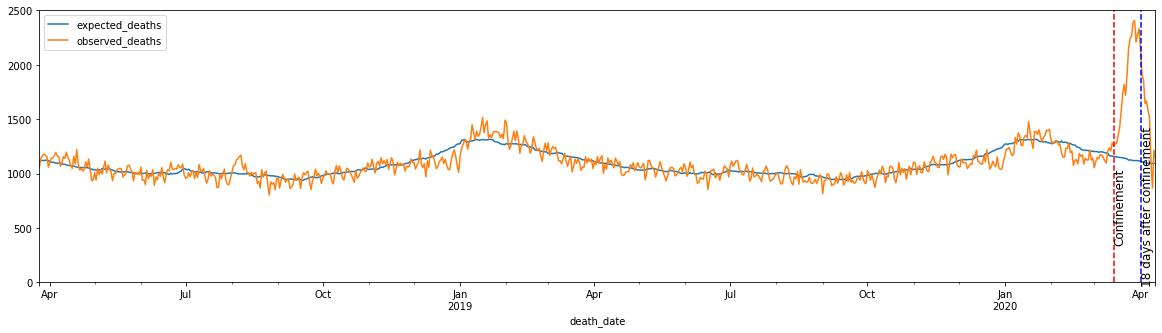

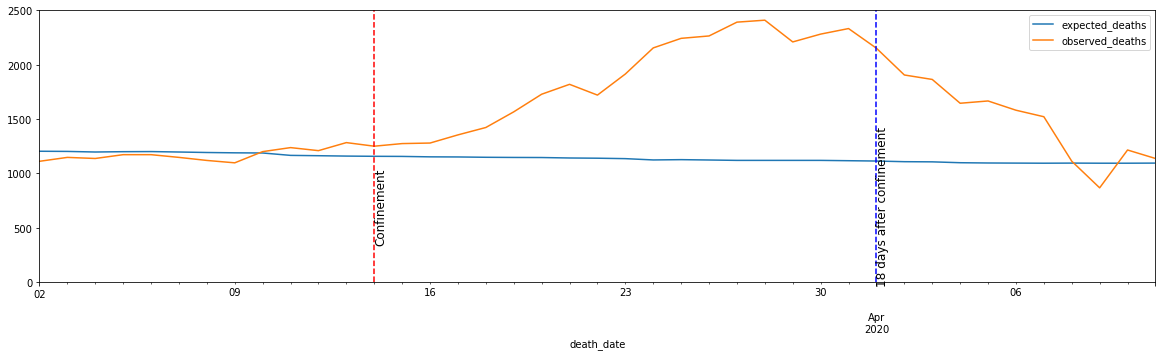

In [216]:
#mortality = mortality.iloc[:-4,:] #According to the site, info from the last few days is not enterely reliable. 
ax = mortality.plot(x="death_date", y= ["expected_deaths", "observed_deaths"], figsize=(20,5), ylim=(0,2500))
ax.axvline(confinement_date, color='red', linestyle='--') # red line for the beginning of the confinement
ax.axvline(eighteen_days_after_confinement, color='b', linestyle='--') # blue line for the beginning of the effects from the confinement
ax.text(x=confinement_date,  y=700,s="Confinement", fontsize=12, rotation=90, verticalalignment='center')
ax.text(x=eighteen_days_after_confinement,  y=700,s="18 days after confinement", fontsize=12, 
        rotation=90, verticalalignment='center')



mortality_march = mortality[mortality["death_date"] > "2020-03-01"]
ax = mortality_march.plot(x="death_date", y= ["expected_deaths", "observed_deaths"], figsize=(20,5), ylim=(0,2500))
ax.axvline(confinement_date, color='red', linestyle='--') # red line for the beginning of the confinement
ax.axvline(eighteen_days_after_confinement, color='b', linestyle='--') # blue line for the beginning of the effects from the confinement
ax.text(x=confinement_date,  y=700,s="Confinement", fontsize=12, rotation=90, verticalalignment='center')
ax.text(x=eighteen_days_after_confinement,  y=700,s="18 days after confinement", fontsize=12, 
        rotation=90, verticalalignment='center')




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


18451.0

El dia 4 de aBril se suponia que habia solo 11744 muertes por corona y a mi me salen 17075.0
Eso significa que había 

In [193]:
(17075.0 - 11744) / 11744

0.45393392370572205

In [194]:
17075 / 0.017

1004411.7647058823

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(2020-04-01, 700, '18 days after confinement')

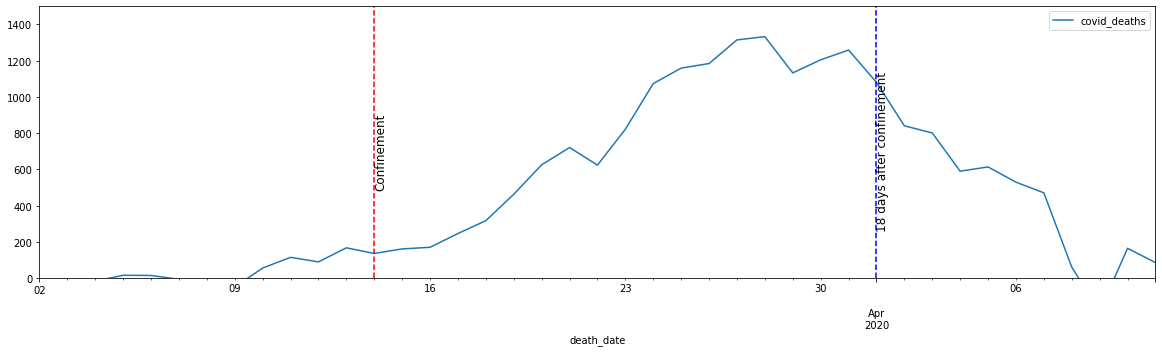

In [215]:
mortality_excess = mortality[mortality["death_date"] > "2020-03-01"]
mortality_excess["covid_deaths"] = (mortality_excess["observed_deaths"] 
                                    - mortality_excess["expected_deaths"] 
                                    + death_to_discount
                                   )
mortality_excess["covid_deaths"].sum()


ax = mortality_excess.plot(x="death_date", y= ["covid_deaths"], figsize=(20,5), ylim=(0,1500))
ax.axvline(confinement_date, color='red', linestyle='--') # red line for the beginning of the confinement
ax.axvline(eighteen_days_after_confinement, color='b', linestyle='--') # blue line for the beginning of the effects from the confinement


ax.text(x=confinement_date,  y=700,s="Confinement", fontsize=12, rotation=90, verticalalignment='center')
ax.text(x=eighteen_days_after_confinement,  y=700,s="18 days after confinement", fontsize=12, 
        rotation=90, verticalalignment='center')




# Next Steps:
    - To do the same but to a regional level. data from Movo and Inem is avaibla for province
    - Add official data 
    
# Limitations:
    - Debido a la sobrecarga del sistema sanitario, el numero de muertes durante la prmera quincena del mes de marzo ha podido sue superior al esperado 
    - Confinement is going to have an important impact on the trasmission of the virus. We should consider the transmission rate is going to change before, after and even depending the severity of the confinement
    